In [1]:
import os
import sys
import math
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

==================== Computational Cancer Analysis Library ====================
<01:16:28.285920> Checking dependencies ...
<01:16:28.288070> Using the following packages:
<01:16:28.289735> 	matplotlib (v1.5.1)
<01:16:28.289752> 	numpy (v1.10.4)
<01:16:28.289761> 	pandas (v0.18.0)
<01:16:28.289782> 	rpy2 (v2.7.9)
<01:16:28.289790> 	scikit-learn (v0.17.1)
<01:16:28.289798> 	scipy (v0.17.0)
<01:16:28.289805> 	seaborn (v0.7.0)


In [2]:
features = ccal.support.read_gct('/Users/Kwat/Downloads/v22_pub.gct')
component_x_cellline = ccal.support.read_gct('/Users/Kwat/Downloads/CCLE.rpkm.v2.SELECTED_SIGNATURES.v2.gct')
ref = component_x_cellline.ix['KRAS_SALE_Late_Comp_C1_9', :]

In [3]:
features_random = ccal.support.make_random_features(10, 10)
ref_random = ccal.support.make_random_features(1, 10)

<01:19:05.929774> Computing features vs. KRAS_SALE_Late_Comp_C1_9 using information_coef metric ...
<01:19:05.929984> Using 597 intersecting columns from features and ref, which have 645 and 750 columns respectively ...
<01:19:28.620923> Bootstrapping to get 0.95 confidence interval ...
<01:19:46.511405> Performing permutation test with 1 permutations ...
<01:20:08.146050> Plotting top 5 features vs. ref ...
<01:20:08.150047> Plotting top and bottom 10 features ...
<01:20:08.152124> Normalizing continuous features ...
<01:20:08.973697> Normalizing continuous ref ...


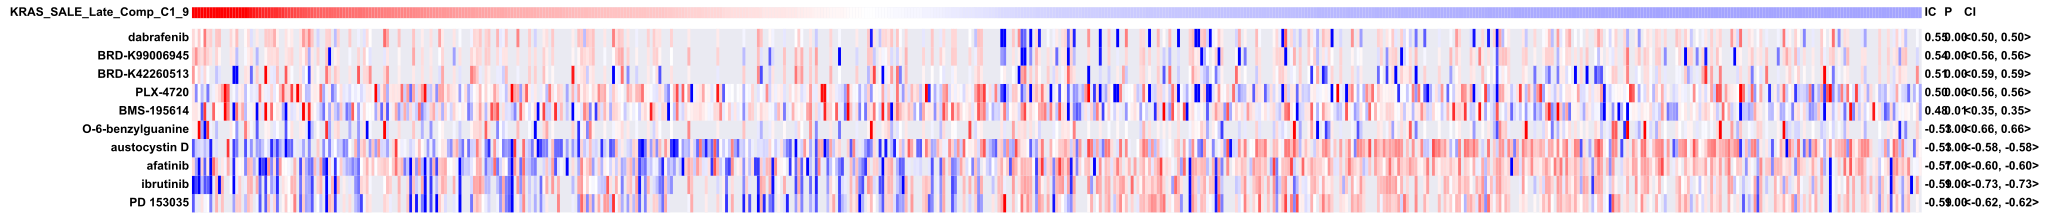

In [5]:
ccal.analyze.rank_features_against_reference(features, ref, n_sampling=1, n_perm=1, n_features=5)

In [6]:
# Test IC
x = np.random.random_sample(10)
y = np.random.random_sample(10)
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
y = np.random.random_sample(11)
try:
    ccal.information.information_coefficient(x, y)
except ValueError as e:
    print(e)

x = np.random.random_sample(10)
x[1] = None
y = np.random.random_sample(10)
y[2] = None
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
x[1] = None
y = np.random.random_sample(10)
y[2] = None
y[6] = None
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
x[1] = None
x[3] = None
x[5] = None
y = np.random.random_sample(10)
y[2] = None
y[4] = None
print(ccal.information.information_coefficient(x, y))

x = np.array([12.517, 14.706, np.nan, 14.12, np.nan, np.nan, np.nan, 12.255])
y = np.array([0.98246356, 0.97525171, 0.77744759, 0.64084311, 0.4405853, 0.43827196, 0.12447757, 0.08116039])
print(ccal.information.information_coefficient(x, y))

-0.228591846314
Input arrays have different lengths: 11 & 10.
-0.767499189677
0.749091939458
-0.176385585712
0.35591890868
